# Study data

In [4]:
import argparse
import os
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

#from gail import girdworld_gail, Reward
from trafficenv import TrafficEnv
from agents import AgentCNN as Agent
#from experts import expert
from utils import load,load_all_mode


from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
N_modes = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
expert_states, expert_actions, expert_test_states, expert_test_actions, clusterers = load_all_mode(device,modes_n=N_modes,return_clusterers=True)



c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
(expert_states[:,8]==2).cpu().numpy().astype(float).mean()

0.230113709865204

In [22]:
print(np.unique(np.round(expert_actions[:,:2]),axis=0,return_counts=True))

(array([[-1.,  0.],
       [-0., -1.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 1., -1.],
       [ 1., -0.],
       [ 1.,  1.],
       [ 2., -1.],
       [ 2., -0.],
       [ 2.,  1.],
       [ 3., -1.],
       [ 3., -0.],
       [ 3.,  1.],
       [ 4.,  0.],
       [ 5., -0.],
       [ 6.,  0.],
       [ 7., -0.],
       [ 8., -0.]], dtype=float32), array([    12,      7, 109685,      8,     13, 157888,     58,      9,
        30898,     93,      2,   6803,      4,   1171,   1354,   1153,
           49,      1], dtype=int64))


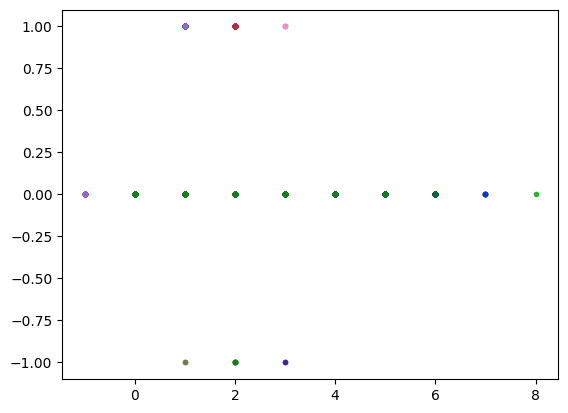

In [11]:
type_ = 2
mask_type = (expert_states[:,8]==type_)
center = [10,6]# r,c
prob_mask = np.zeros((20,30,20))
for i in range(N_modes):
    #if i!=:continue
    mask = mask_type*(expert_actions[:,2]==i)
    #plt.scatter(expert_actions[mask][:,0],expert_actions[mask][:,1],linewidths=1,marker='.',color=np.random.rand(3))
    pnt_poses, probs = np.unique(np.round(expert_actions[mask][:,:2]),axis=0,return_counts=True)
    #probs /= expert_actions[mask].shape[0]
    prob_mask[center[0]-1-pnt_poses[:,1].T.astype(int),pnt_poses[:,0].T.astype(int)+center[1]-1,np.ones(pnt_poses.shape[0]).astype(int)*i] = probs/expert_actions[mask].shape[0]
    #print(np.unique(np.round(expert_actions[mask][:,:2]),axis=0))
    plt.scatter(np.round(expert_actions[mask][:,0]),np.round(expert_actions[mask][:,1]),linewidths=1,marker='.',color=np.random.rand(3))
plt.show()

In [10]:
prob_mask

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [30]:
expert_states[(expert_states[:,0]<11)*(expert_states[:,0]>10)*(expert_states[:,8]==2)*(expert_states[:,9]>1)*(expert_states[:,9]<1.3)*(expert_states[:,7]==0)][:,:10]#.shape

tensor([[10.7512, -2.6516,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.1954],
        [10.0917, -2.6640,  1.0000,  2.0000,  2.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.2197],
        [10.9791, -2.6836,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.2839],
        [10.4197, -2.6905,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.2803],
        [10.4422, -2.6826,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.0203],
        [10.1441, -2.6735,  0.0000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000,
          2.0000,  1.0987]])

In [74]:
from bc import AgentCNN_Z_BC_MB
model_bc = torch.load(f'bc_agent_ind_{20}_{N_modes}_one_step.pth',map_location=torch.device('cpu'))

In [80]:
model_bc.get_action(expert_test_states[:10,:10])[0] - expert_test_actions[:10,:2]

tensor([[ 0.0440,  0.0159],
        [ 0.0833,  0.0163],
        [ 0.0920,  0.0531],
        [ 0.0959,  0.0104],
        [ 0.0738,  0.0383],
        [ 0.0703,  0.0259],
        [ 0.0658, -0.0029],
        [-0.0038,  0.0145],
        [ 0.0137,  0.0062],
        [ 0.0679,  0.0209]], grad_fn=<SubBackward0>)

In [91]:
expert_states[expert_states[:,8]==2][:,0].mean()

tensor(2.7792)

In [32]:
expert_actions[[(expert_states[:,0]<11)*(expert_states[:,0]>10)*(expert_states[:,8]==2)*(expert_states[:,9]>1)*(expert_states[:,9]<1.3)*(expert_states[:,7]==0)]]

tensor([[ 4.2114e+00,  3.0225e-03,  0.0000e+00],
        [ 3.9413e+00, -5.5203e-02,  9.0000e+00],
        [ 4.2794e+00, -6.9744e-02,  0.0000e+00],
        [ 4.0627e+00, -2.3346e-02,  9.0000e+00],
        [ 4.0909e+00,  5.8552e-02,  9.0000e+00],
        [ 4.0098e+00,  1.0516e-01,  9.0000e+00]])

In [54]:
a = expert_test_states
a[(a[:,0]<5)*(a[:,0]>4)*(a[:,8]==2)*(a[:,7]==0)*(a[:,1]>2.1)][:,:10]#.shape#*(a[:,9]>1)#(a[:,0]<11)**(a[:,9]<1.3)
expert_test_actions[(a[:,0]>5)*(a[:,0]>4)*(a[:,8]==2)*(a[:,7]==0)*(a[:,1]>2.1)][:,:10]#.shape#*(a[:,9]>1)#(a[:,0]<11)**(a[:,9]<1.3)

tensor([[ 3.0857, -0.0238,  4.0000],
        [ 3.8275, -0.2367,  9.0000],
        [ 2.3173, -0.0871, 11.0000],
        [ 2.7094, -0.1277,  4.0000],
        [ 3.1124, -0.1076, 16.0000],
        [ 2.1973,  0.1337, 11.0000],
        [ 2.0201,  0.2052, 13.0000],
        [ 3.2612, -0.0638, 16.0000],
        [ 3.1598, -0.0229, 16.0000],
        [ 3.0308, -0.0245,  4.0000],
        [ 3.1843,  0.0323, 16.0000],
        [ 3.6810, -0.0776,  9.0000]])

In [72]:
a[(a[:,8]==2)]
a[:,1].max()

tensor(3.1284)

In [2]:

type_ = 2
if type_==0:
    yx_all = np.load('ind_train_ped.npy')
    yx_test_all = np.load('ind_test_ped.npy')
elif type_==1:
    yx_all = np.load('ind_train_bi.npy')
    yx_test_all = np.load('ind_test_bi.npy')
elif type_==2:
    yx_all = np.load('ind_train_car.npy')
    yx_test_all = np.load('ind_test_car.npy')
elif type_==3:
    yx_all = np.load('ind_train_truck.npy')
    yx_test_all = np.load('ind_test_truck.npy')


# yx format
# y: 24, x, y [0-11]
# x: cx ,cy ,heading ,vx ,vy ,ax ,ay ,width ,length, vru5 ,vru10 ,vru20, nonvru5 ,nonvru10 ,nonvru20 ==> (15*8)

yx_all.shape # 144 = 24+15*8


(71153, 144)

In [169]:
step = 2
(yx_all[:,step*2]>0).sum()/yx_all.shape[0]

0.07230957382689754

In [97]:
yx_all = yx_all[(abs(yx_all[:,:24])>0.05).any(axis=1)]#.shape

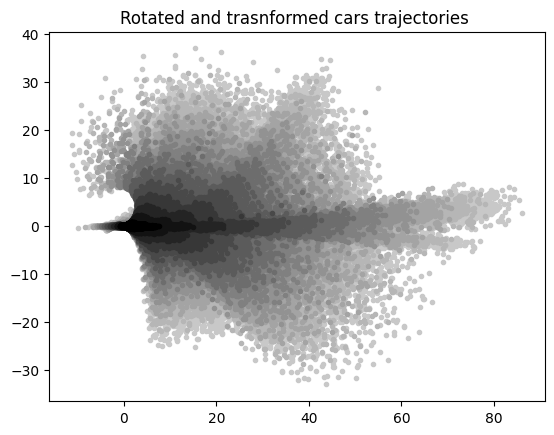

In [8]:
step = 11
for step in reversed(range(12)):

    plt.scatter(yx_all[:,step*2],yx_all[:,step*2+1],linewidths=1,marker='.',color=np.array([1/14,1/14,1/14])*step)
plt.title('Rotated and trasnformed cars trajectories ')
plt.show()

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


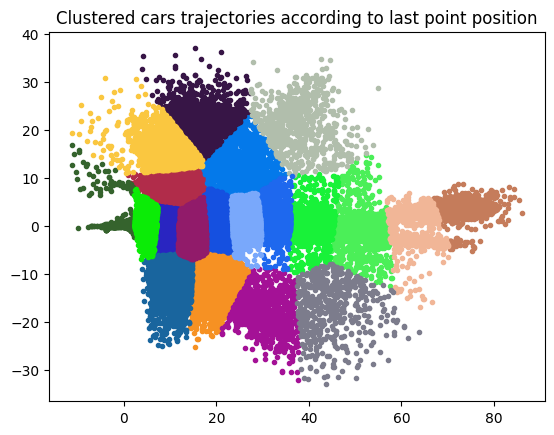

In [6]:
# clustering
from sklearn.cluster import KMeans
n_modes = 20
clusterer = KMeans(n_clusters=n_modes,random_state=42).fit(yx_all[:,22:24])#,n_init=10

for m in range(n_modes):
    mask = (clusterer.labels_==m)
    plt.scatter(yx_all[mask][:,22],yx_all[mask][:,23],linewidths=1,marker='.',color=np.random.rand(3))#np.array([1/9,1/9,1/9])*step)
plt.title('Clustered cars trajectories according to last point position')
plt.show()
#expert_actions_ = (np.hstack((expert_actions_,clusterer.labels_[:,None])))#.to(device)

## Centers

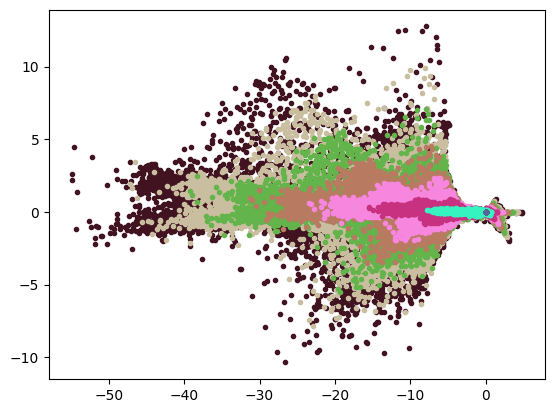

In [161]:
for step in (range(8)): # not reversed

    plt.scatter(yx_all[:,24+step*15],yx_all[:,25+step*15],linewidths=1,marker='.',color=np.random.rand(3))#np.array([1/9,1/9,1/9])*step)
plt.show()

(array([185496.,  72060.,    850., 325558.,    411., 123050.,  65677.,
          4769.,  75190.,   1404.]),
 array([3.84000000e-03, 3.60022010e+01, 7.20005620e+01, 1.07998923e+02,
        1.43997284e+02, 1.79995645e+02, 2.15994006e+02, 2.51992367e+02,
        2.87990728e+02, 3.23989089e+02, 3.59987450e+02]),
 <BarContainer object of 10 artists>)

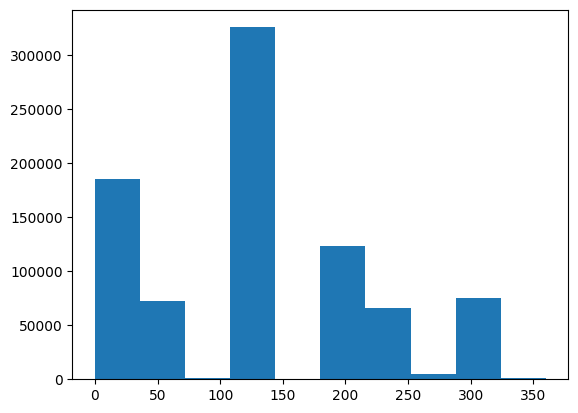

In [64]:
step = 7
plt.hist(yx_all[:,26+15*step]) # headings

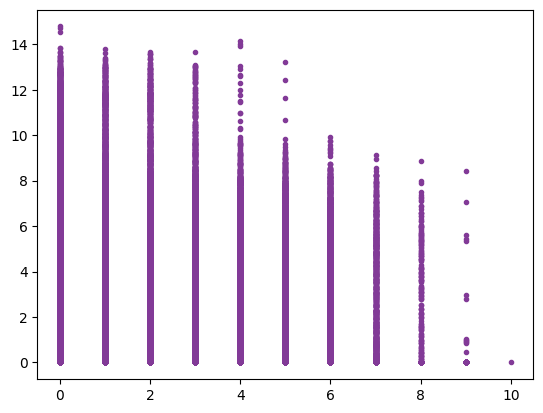

In [70]:
step = 7#7 input (7 is the most recent one)
step_move = 2#11 output
speed_x = np.linalg.norm(yx_all[:,step_move*2:step_move*2+1],axis=1)
plt.scatter(yx_all[:,37+15*step], speed_x, linewidths=1, marker='.' ,color=np.random.rand(3))#np.array([1/9,1/9,1/9])*step)
plt.show()

In [124]:
yx_all[:,27+105:29+105].max()

12.694722951416814

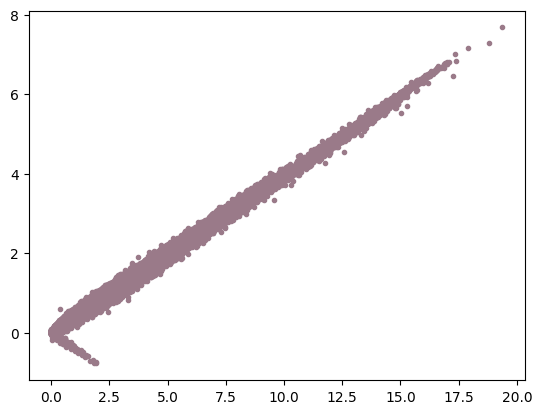

In [163]:
step = 7#11 output 
speed_vx = np.linalg.norm(yx_all[:,24+3+105-0:26+3+105-0],axis=1)
sin_h = -np.cos(yx_all[:,26+105:27+105]*np.pi/180)
plt.scatter(speed_vx,yx_all[:,:1], linewidths=1, marker='.' ,color=np.random.rand(3))#np.array([1/9,1/9,1/9])*step)
plt.show()

In [145]:
yx_all[:,:1]/sin_h

array([[ 0.01748682],
       [-0.00137673],
       [ 0.00764696],
       ...,
       [ 0.01365593],
       [ 0.00750626],
       [ 0.00031787]])

In [110]:
yx_all[:,:1].max()

4.148261562299731

In [42]:
speed_x.shape

(196123,)

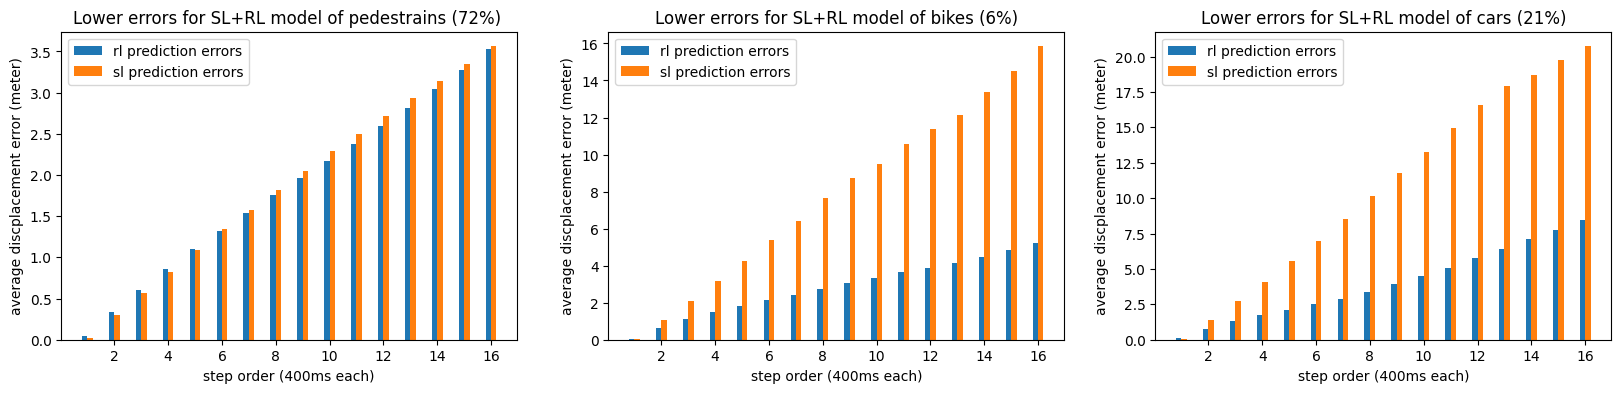

In [6]:
from results_unid import *
peds = []
for x,y  in zip(type_0,type_0_):
    peds.append((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]))

peds_last = []
for x,y  in zip(type_0_bc_last,type_0_bc_last_):
    peds_last.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))
    
peds_first = []
for x,y  in zip(type_0_bc_first,type_0_bc_first_):
    peds_first.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))
    
    
bikes = []
for x,y  in zip(type_1,type_1_):
    bikes.append((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]))

bikes_last = []
for x,y  in zip(type_1_bc_last,type_1_bc_last_):
    bikes_last.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))
    
bikes_first = []
for x,y  in zip(type_2_bc_first,type_2_bc_first_):
    bikes_first.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))   


cars = []
for x,y  in zip(type_2,type_2_):
    cars.append((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]))

cars_last = []
for x,y  in zip(type_2_bc_last,type_2_bc_last_):
    cars_last.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))
    
cars_first = []
for x,y  in zip(type_2_bc_first,type_2_bc_first_):
    cars_first.append((x[0]*x[1] + y[0]*y[1])/(x[1]+y[1]))

    
#all_peds = np.array([peds,peds_last]).T.flatten()
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.bar(np.array(range(1,1+(16),1))-0.1,peds[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,peds_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for SL+RL model of pedestrains (72%) ')
plt.legend()

plt.subplot(1,3,2)
plt.bar(np.array(range(1,1+(16),1))-0.1,bikes[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,bikes_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for SL+RL model of bikes (6%)')
plt.legend()

plt.subplot(1,3,3)
plt.bar(np.array(range(1,1+(16),1))-0.1,cars[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,cars_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for SL+RL model of cars (21%)')
plt.legend()

plt.show()

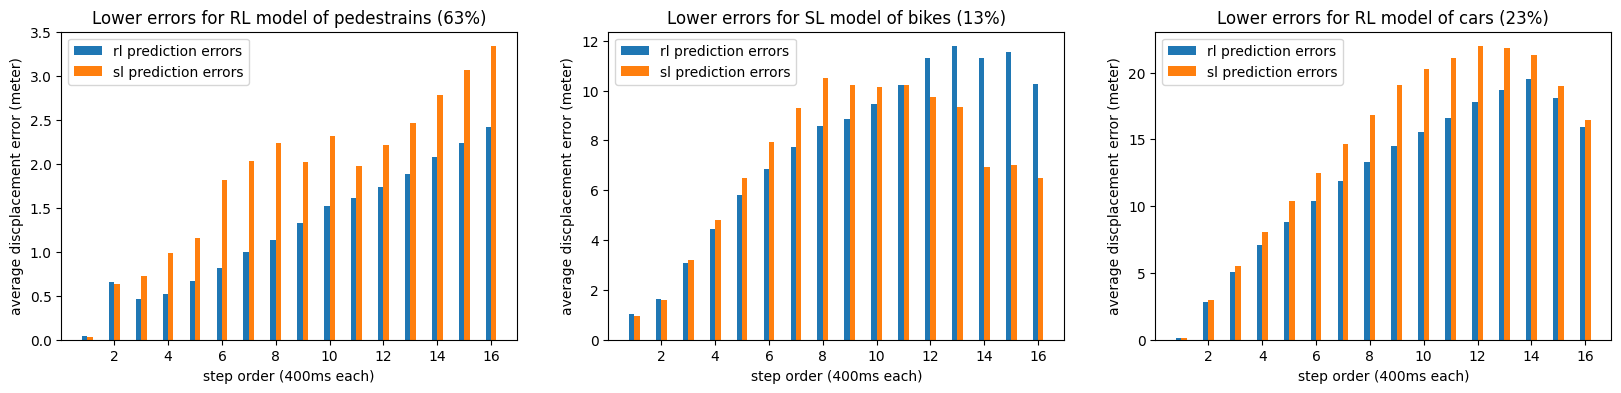

In [9]:
from results_ind import *
peds = []
for x,y,z  in zip(rl_v30_0,rl_v31_0,rl_v32_0):
    peds.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

peds_last = []
for x,y,z  in zip(bc_v30_0,bc_v31_0,bc_v32_0):
    peds_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    
    
bikes = []
for x,y,z  in zip(rl_v30_1,rl_v31_1,rl_v32_1):
    bikes.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

bikes_last = []
for x,y,z  in zip(bc_v30_1,bc_v31_1,bc_v32_1):
    bikes_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    
    
cars = []
for x,y,z  in zip(rl_v30_2,rl_v31_2,rl_v32_2):
    cars.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

cars_last = []
for x,y,z  in zip(bc_v30_2,bc_v31_2,bc_v32_2):
    cars_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    


#all_peds = np.array([peds,peds_last]).T.flatten()
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.bar(np.array(range(1,1+(16),1))-0.1,peds[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,peds_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for RL model of pedestrains (63%)')
plt.legend()

plt.subplot(1,3,2)
plt.bar(np.array(range(1,1+(16),1))-0.1,bikes[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,bikes_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for SL model of bikes (13%)')
plt.legend()

plt.subplot(1,3,3)
plt.bar(np.array(range(1,1+(16),1))-0.1,cars[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,cars_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for RL model of cars (23%)')
plt.legend()

plt.show()

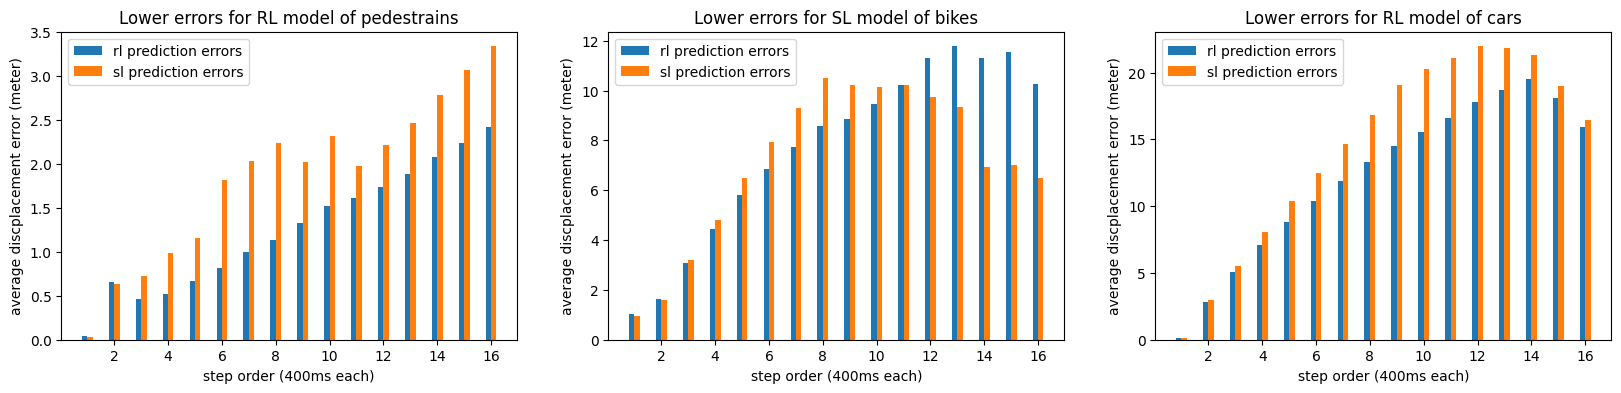

In [2]:
from results_ind import *
peds = []
for x,y,z  in zip(rl_v30_0,rl_v31_0,rl_v32_0):
    peds.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

peds_last = []
for x,y,z  in zip(bc_v30_0,bc_v31_0,bc_v32_0):
    peds_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    
    
bikes = []
for x,y,z  in zip(rl_v30_1,rl_v31_1,rl_v32_1):
    bikes.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

bikes_last = []
for x,y,z  in zip(bc_v30_1,bc_v31_1,bc_v32_1):
    bikes_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    
    
cars = []
for x,y,z  in zip(rl_v30_2,rl_v31_2,rl_v32_2):
    cars.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))

cars_last = []
for x,y,z  in zip(bc_v30_2,bc_v31_2,bc_v32_2):
    cars_last.append((x[0]*x[1]+y[0]*y[1]+z[0]*z[1])/(x[1]+y[1]+z[1]))
    

    
#all_peds = np.array([peds,peds_last]).T.flatten()
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.bar(np.array(range(1,1+(16),1))-0.1,peds[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,peds_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for RL model of pedestrains')
plt.legend()

plt.subplot(1,3,2)
plt.bar(np.array(range(1,1+(16),1))-0.1,bikes[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,bikes_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for SL model of bikes (06)')
plt.legend()

plt.subplot(1,3,3)
plt.bar(np.array(range(1,1+(16),1))-0.1,cars[:16],width=0.2,label='rl prediction errors')
plt.bar(np.array(range(1,1+(16),1))+0.1,cars_last[:16],width=0.2,label='sl prediction errors')
plt.xlabel('step order (400ms each)')
plt.ylabel('average discplacement error (meter)')
plt.title('Lower errors for RL model of cars')
plt.legend()

plt.show()

In [4]:
peds_last

[0.015437991746999434,
 0.2970129736968738,
 0.5630722017270878,
 0.8268336176430208,
 1.0894134244422424,
 1.3396312011427975,
 1.5764511074612082,
 1.8139711313293494,
 2.0547016288899815,
 2.2863045332729754,
 2.503755647880738,
 2.7135554539078166,
 2.9292806081415,
 3.1455453221711642,
 3.3468534654436035,
 3.5619909663807374,
 3.76117297024223,
 3.986330716458435,
 4.206634046787286,
 4.438253490423913,
 4.66570555562786,
 4.864299075870461,
 5.054010789735074,
 5.283509217551413,
 5.507253173553304,
 5.75851201567807,
 5.958740375344389,
 6.190967554632445,
 6.4319490301892195,
 6.678666308923957,
 6.883419274315054]

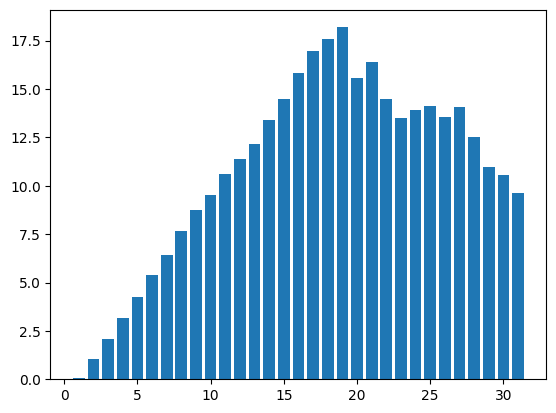

In [12]:
from results_unid import *

import importlib

    
plt.bar(range(1,32),peds_)
plt.show()

In [13]:
np.array(peds_)>np.array(peds)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False])